In [6]:
import numpy as np 
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [7]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
train = pd.read_csv('dataset/data.csv')

In [11]:
train.head()

,game_id,game_name,recommendation_id,user_id,num_games_owned,num_reviews,playtime_forever,playtime_at_review,review,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,1097150,Fall Guys,73899674,76561198104502231,52,22,658,253,"I gave a little Hug to a player, he stared bac...",1596781693,1,984,1451,0.947646,0,1,0,0
1,1097150,Fall Guys,73735619,76561198142247081,488,131,751,8,It's nice to have BR that's just about having ...,1596526002,1,2634,173,0.947115,18,1,0,0
2,1097150,Fall Guys,73738009,76561198041994478,1352,15,366,80,This game is fantastic. The devs are super inv...,1596529738,1,985,39,0.942068,1,1,0,0
3,1097150,Fall Guys,73848436,76561198025307988,1795,3,1672,866,"Fun in short bursts, tedious in long stretches...",1596693931,1,613,7,0.935590,12,0,1,0
4,1097150,Fall Guys,73781849,76561198089118754,50,2,203,30,wish there was an 8 party option,1596587937,1,553,6,0.935560,0,0,0,0


Percent of positive entries 83.792 %


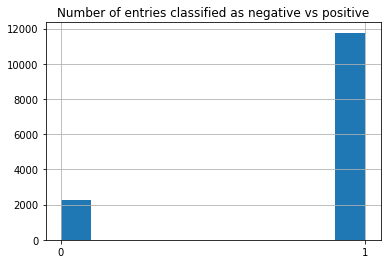

In [13]:
fig,ax = plt.subplots(1,1)
train.hist(column = 'voted_up', ax = ax)
ax.set_title('Number of entries classified as negative vs positive')
ax.set_xticks([0,1])
print('Percent of positive entries %.3f %%'%(100*(sum(train['voted_up'])/len(train))))

In [14]:
embeddings_index = {}
f = open('glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split(' ')
    word = values[0] 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [17]:
import re
## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in train['review'].values: 
    line = str(line).lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

print(texts[0:5])

[['gave', 'little', 'hug', 'player', 'stared', 'back', '5', 'seconds', 'jumped', 'map', 'killed', 'never', 'felt', 'much', 'power', 'moment'], ['nice', 'br', 'fun', '10', '10', 'would', 'fall'], ['game', 'fantastic', 'devs', 'super', 'involved', 'community', 'future', 'seems', 'really', 'bright', 'takeshi', 'castle', 'influence', 'strong', 'fans', 'show', 'practically', 'hugging', 'simulator'], ['fun', 'short', 'bursts', 'tedious', 'long', 'stretches', 'moment', '75', 'minigames', 'need', 'sort', 'rework', 'early', 'game', 'race', 'maps', 'need', 'random', 'factors', 'make', 'replays', 'feel', 'varied', 'unpredictable', 'punishing', 'since', 'first', 'levels', 'survival', 'games', 'like', 'roll', 'block', 'party', 'perfect', 'match', 'need', 'always', 'end', 'based', 'eliminations', 'need', 'faster', 'harder', 'right', 'easy', 'chore', 'team', 'games', 'basically', 'random', 'chance', 'takes', '3', 'minutes', 'determine', 'whether', 'team', 'performance', 'irrelevant', 'individual', 'o

In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
MAX_NUM_WORDS = 1000
MAX_SEQUENCE_LENGTH = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(train['voted_up']))
print(data.shape)
print(labels.shape)

Found 25501 unique tokens.
(14036, 100)
(14036, 2)


In [20]:
from keras.layers import Embedding
from keras.initializers import Constant
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(1001, 300)


Text(0.5, 1.0, 'example vectors')

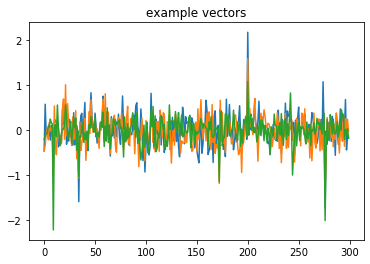

In [21]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

model = Sequential()
model.add(Embedding(num_words, 300, input_length=100, weights= [embedding_matrix], trainable=False))

model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
print(labels.shape)
model.fit(data, np.array(labels), validation_split=0.1, epochs = 1)

(14036, 2)
Train on 12632 samples, validate on 1404 samples
Epoch 1/1
12632/12632 [==============================] - 40s 3ms/step - loss: 0.3541 - acc: 0.8597 - val_loss: 0.3237 - val_acc: 0.8697


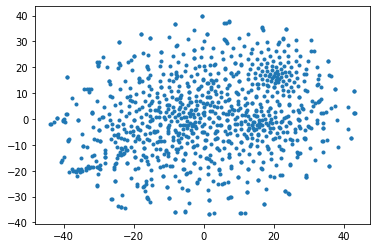

In [24]:
from sklearn.manifold import TSNE
## Get weights
embds = model.layers[0].get_weights()[0]
## Plotting function
## Visualize words in two dimensions 
tsne_embds = TSNE(n_components=2).fit_transform(embds)

plt.plot(tsne_embds[:,0],tsne_embds[:,1],'.')